In [1]:
import collections

import numpy as np
import tensorflow as tf
import tensorflow_federated as tff

import nest_asyncio
from tensorflow.keras import activations
nest_asyncio.apply()

tff.backends.reference.set_reference_context()

/home/deravindusilva/anaconda3/lib/python3.8/site-packages/tensorflow_addons/utils/ensure_tf_install.py:37: UserWarning: You are currently using a nightly version of TensorFlow (2.5.0-dev20210101). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


### Before we start

In [2]:
@tff.federated_computation
def hello_world():
    return 'Hello, World!'

hello_world()

'Hello, World!'

### DATA set

#### Trainig 

[[ 2.30849032 -2.67600245]
 [ 1.53008141 -1.07910449]
 [-2.59848666  3.39073266]
 ...
 [-1.82165036  1.2723548 ]
 [ 1.91850361 -2.26326995]
 [-2.48056254 -1.92813686]]
**********
[1 1 0 ... 0 1 2]


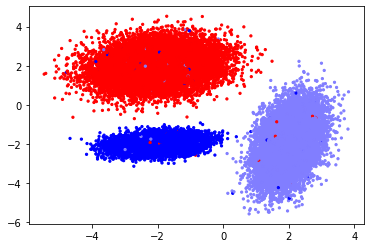

In [3]:
import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import sklearn.datasets as dt

from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

x,y = dt.make_classification(n_samples=45000,
                                 n_features=2,
                                 n_repeated=0,
                                 class_sep=2,
                                 n_redundant=0,
                                 n_classes=3,
                                 n_clusters_per_class=1,
                                 random_state=1000)

print(x)
print("**********")
print(y)

my_scatter_plot = plt.scatter(x[:,0],
                                  x[:,1],
                                  c=y,
                                  vmin=min(y),
                                  vmax=max(y),
                                  s=5,
                                  cmap=color_map_discrete)

plt.show()

In [4]:
list0 = []
list1 = []
list2 = []

for a,b in zip(x,y):
    c = a.tolist()
    c.append(b)
    if b == 0:
        list0.append(c)
    elif b == 1:
        list1.append(c)
    else:
        list2.append(c)

In [5]:
import math

client1 = []
client2 = []
client3 = []

l01 = math.ceil(len(list0)*0.7)
l02 = math.ceil(len(list0)*0.8)

l11 = math.ceil(len(list0)*0.6)
l12 = math.ceil(len(list0)*0.75)

l21 = math.ceil(len(list0)*0.65)
l22 = math.ceil(len(list0)*0.85)


client1 = list0[:l01] + list1[l11:l12] + list2[l22:]


client2 = list0[l02:] + list1[:l11] + list2[l21:l22]


client3 = list0[l01:l02] + list1[l12:] + list2[:l21]

In [6]:
import random 
random.shuffle(client1)
random.shuffle(client2)
random.shuffle(client3)

In [7]:
from tqdm.notebook import tqdm as tqdm_notebook
import numpy as np

def get_batches(HOLDER):
    federated_data = []
    for i in tqdm_notebook(HOLDER):
        client = []
        for index in range(len(i)//100):
            X= []
            Y= []
            for elements in i[index*100:index*100+100]:
                X.append(np.array([np.float32(elements[0]),np.float32(elements[1])]))
                Y.append(np.array(np.int32(elements[2])))
            client.append({
                'x':np.array(X),
                'y':np.array(Y)
            })
        federated_data.append(client)
    return federated_data

In [8]:
def poissonDistributiondata(clientData):
    data = random.sample(clientData,2000)
    return [data[:1000],data[1000:1500],data[1500:]]

In [9]:
c1_tra, c1_val, c1_test = poissonDistributiondata(client1)
c2_tra, c2_val, c2_test = poissonDistributiondata(client2)
c3_tra, c3_val, c3_test = poissonDistributiondata(client3)

train = [c1_tra, c2_tra, c3_tra]
val = [c1_val, c2_val, c3_val]
test = [c1_test, c2_test, c3_test]

federated_train_data = get_batches(train)
federated_validation_data = get_batches(val)
federated_test_data = get_batches(test)

### Implementing Federated Averaging

In [10]:
BATCH_SPEC = collections.OrderedDict(
    x=tf.TensorSpec(shape=[None, 2], dtype=tf.float32),
    y=tf.TensorSpec(shape=[None], dtype=tf.int32))
BATCH_TYPE = tff.to_type(BATCH_SPEC)

str(BATCH_TYPE)

'<x=float32[?,2],y=int32[?]>'

In [11]:
MODEL_SPEC = collections.OrderedDict(
    weights=tf.TensorSpec(shape=[2, 3], dtype=tf.float32),
    bias=tf.TensorSpec(shape=[3], dtype=tf.float32))
MODEL_TYPE = tff.to_type(MODEL_SPEC)

print(MODEL_TYPE)

<weights=float32[2,3],bias=float32[3]>


In [12]:
@tf.function
def forward_pass(model, batch):
    predicted_y = tf.nn.softmax(tf.matmul(batch['x'], model['weights']) + model['bias'])
    return -tf.reduce_mean(tf.reduce_sum(tf.one_hot(batch['y'], 3) * tf.math.log(predicted_y), axis=[1]))

@tff.tf_computation(MODEL_TYPE, BATCH_TYPE)
def batch_loss(model, batch):
    return forward_pass(model, batch)

In [13]:
initial_model = collections.OrderedDict(
    weights=np.zeros([2, 3], dtype=np.float32),
    bias=np.zeros([3], dtype=np.float32))

In [14]:
sample_batch = federated_train_data[1][0]

batch_loss(initial_model, sample_batch)

1.0986123

In [31]:
WEIGHT_SPEC = tff.TensorType(
    dtype=tf.float32, shape=[1]
)
WEIGHT_TYPE = tff.to_type(WEIGHT_SPEC)

In [32]:
WEIGHT_DATA_TYPE = tff.FederatedType(WEproIGHT_TYPE, tff.CLIENTS)

### Gradient descent on a single batch

In [15]:
@tff.tf_computation(MODEL_TYPE, BATCH_TYPE, tf.float32)
def batch_train(initial_model, batch, learning_rate):
    model_vars = collections.OrderedDict([
        (name, tf.Variable(name=name, initial_value=value))
        for name, value in initial_model.items()
    ])
    optimizer = tf.keras.optimizers.SGD(learning_rate)
    
    @tf.function
    def _train_on_batch(model_vars, batch):
        # Perform one step of gradient descent using loss from `batch_loss`.
        with tf.GradientTape() as tape:
            loss = forward_pass(model_vars, batch)
        grads = tape.gradient(loss, model_vars)
        optimizer.apply_gradients(zip(tf.nest.flatten(grads), tf.nest.flatten(model_vars)))
        return model_vars
  
    return _train_on_batch(model_vars, batch)

Now, let's apply this function a few times to the initial model to see whether the loss decreases

In [16]:
model = initial_model
losses = []
for _ in range(5):
    model = batch_train(model, sample_batch, 0.1)
    losses.append(batch_loss(model, sample_batch))
print(losses)

[0.8020243, 0.6346225, 0.5322095, 0.46333915, 0.41344887]


### Gradient descent on the client (all batches)

In [17]:
LOCAL_DATA_TYPE = tff.SequenceType(BATCH_TYPE)

@tff.federated_computation(MODEL_TYPE, tf.float32, LOCAL_DATA_TYPE)
def local_train(initial_model, learning_rate, all_batches):
    # Mapping function to apply to each batch.
    @tff.federated_computation(MODEL_TYPE, BATCH_TYPE)
    def batch_fn(model, batch):
        return batch_train(model, batch, learning_rate)
    return tff.sequence_reduce(all_batches, initial_model, batch_fn)

In [18]:
str(local_train.type_signature)

'(<initial_model=<weights=float32[2,3],bias=float32[3]>,learning_rate=float32,all_batches=<x=float32[?,2],y=int32[?]>*> -> <weights=float32[2,3],bias=float32[3]>)'

In [19]:
#Test
locally_trained_model = local_train(initial_model, 0.1, federated_train_data[1])
# print(locally_trained_model)

TODO(b/120157713): Replace with `tff.sequence_average()` once implemented.

In [20]:
@tff.federated_computation(MODEL_TYPE, LOCAL_DATA_TYPE)
def local_eval(model, all_batches):
  # TODO(b/120157713): Replace with `tff.sequence_average()` once implemented.
  return tff.sequence_sum(tff.sequence_map(tff.federated_computation(lambda b: batch_loss(model, b), BATCH_TYPE),all_batches))

In [21]:
print('initial_model loss =', local_eval(initial_model,
                                         federated_train_data[0]))
print('locally_trained_model loss =',
      local_eval(locally_trained_model, federated_train_data[0]))

initial_model loss = 10.986122
locally_trained_model loss = 4.0222745


### Federated evaluation

In [22]:
SERVER_MODEL_TYPE = tff.type_at_server(MODEL_TYPE)
CLIENT_DATA_TYPE = tff.type_at_clients(LOCAL_DATA_TYPE)

In [23]:
@tff.federated_computation(SERVER_MODEL_TYPE, CLIENT_DATA_TYPE)
def federated_eval(model, data):
    return tff.federated_mean(tff.federated_map(local_eval, [tff.federated_broadcast(model), data]))

In [24]:
print('initial_model loss =', federated_eval(initial_model,federated_train_data))
print('locally_trained_model loss =',federated_eval(locally_trained_model, federated_train_data))

initial_model loss = 10.986122
locally_trained_model loss = 3.7363882


In [25]:
SERVER_FLOAT_TYPE = tff.type_at_server(tf.float32)


@tff.federated_computation(SERVER_MODEL_TYPE, SERVER_FLOAT_TYPE,
                           CLIENT_DATA_TYPE)
def federated_train(model, learning_rate, data):
    return tff.federated_mean(
          tff.federated_map(local_train, [
          tff.federated_broadcast(model),
          tff.federated_broadcast(learning_rate), data]))

In [26]:
def modelR(weights, biases, data):
    count = 0
    avg = 0
    for j in range(len(federated_test_data[0])):
        l = [np.where(i==max(i))[0][0] for i in activations.sigmoid(np.matmul(federated_test_data[0][j].get('x'), model.get('weights'))).numpy()]
        Y = federated_test_data[0][j].get('y')
        
        for i in range(len(Y)):
            avg+=1
            if l[i] == Y[i]:
                count+= 1
                
    return count/avg

In [27]:
# model = initial_model
# learning_rate = 0.1
# for round_num in range(5):
#     model = federated_train(model, learning_rate, federated_train_data)
#     learning_rate = learning_rate * 0.9
#     loss = federated_eval(model, federated_train_data)
#     print('round {}, loss={}'.format(round_num, loss))

In [28]:
accuracy = 0
model = initial_model
learning_rate = 0.1
count = 0

accuracy_list = []
for i in range(10):
    model = federated_train(model, learning_rate, federated_train_data)
    print(model.get('bias'))
    learning_rate = learning_rate * 0.9
    loss = federated_eval(model, federated_train_data)
    accuracy = modelR(model.get('weights'), model.get('bias'), federated_test_data)
    count+=1
    accuracy_list.append(accuracy)
    print('round {}, loss={}, accuracy={}'.format(count, loss, accuracy)) 

# pickle.dump(accuracy_list, open('90_clients', 'wb'))

[-0.00338167  0.01357643 -0.01019476]
round 1, loss=3.5302140712738037, accuracy=0.99
[ 0.00819877  0.02392832 -0.03212708]
round 2, loss=2.2660138607025146, accuracy=0.99
[ 0.01916986  0.03178892 -0.05095876]
round 3, loss=1.770003318786621, accuracy=0.99
[ 0.02833832  0.03790082 -0.06623913]
round 4, loss=1.5074998140335083, accuracy=0.992
[ 0.0359125   0.04276469 -0.07867718]
round 5, loss=1.3460451364517212, accuracy=0.992
[ 0.04221034  0.04671332 -0.08892366]
round 6, loss=1.2373586893081665, accuracy=0.992
[ 0.04749658  0.04997165 -0.09746823]
round 7, loss=1.1596572399139404, accuracy=0.992
[ 0.05197421  0.05269625 -0.10467046]
round 8, loss=1.101674199104309, accuracy=0.992
[ 0.05579745  0.05499933 -0.11079678]
round 9, loss=1.0569992065429688, accuracy=0.992
[ 0.05908449  0.05696347 -0.11604797]
round 10, loss=1.0217170715332031, accuracy=0.992


In [29]:
###WRONG
print('initial_model test loss =',federated_eval(initial_model, federated_validation_data))
print('trained_model test loss =', federated_eval(model, federated_validation_data))

initial_model test loss = 5.4930615
trained_model test loss = 0.5339277


In [30]:
len(federated_test_data[0])

5